In [31]:
import numpy as np 
import pandas as pd 
import polars as pl
import xgboost as xgb
import os
import gc
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
#import kaggle_evaluation.jane_street_inference_server

#import seaborn as sb
import matplotlib.pyplot as plt
       

In [32]:
path = '/kaggle/input/jane-street-real-time-market-data-forecasting/'
target = 'responder_6'
features = ["date_id", "time_id", "symbol_id"] + [f"feature_{i:02d}" for i in range(79)]

responders = [f"responder_{i}" for i in range(9)]
#responders.remove("responder_6")  # Убираем 'responder_6' из списка
#all_features = features+responders


## Модель

In [3]:
#parameters
# path = '/kaggle/input/jane-street-real-time-market-data-forecasting/'
# n_splits = 8
# fold_size = 212    # in one parquet around 170 date_id
#lag_responders = 


$$ R^2=1−∑w_i*(y_i−y_ihat)^2 / ∑w_i*y_i^2 $$

In [33]:
# function for weighted R2
def weighted_r2(y_true, y_pred, weights):
   
    ss_residual = np.sum(weights*(y_true - y_pred)**2)
    ss_total = np.sum(weights*(y_true)**2)
    
    # Вычисление взвешенного R2
    r2 = 1 - (ss_residual / ss_total)
    return r2

### Model on a batch of data

In [34]:
# Data loading
start_dt = 1698 - 200
end_dt = 1698

X_train = (pl.scan_parquet(os.path.join(path, "train.parquet"))
           .filter(pl.col("date_id").is_between(start_dt, end_dt))
           .drop(responders)
           .drop('partition_id', 'weight')
           .collect()
           .to_numpy()
           .astype(np.float32))

y_train = (pl.scan_parquet(os.path.join(path, "train.parquet"))
           .filter(pl.col("date_id").is_between(start_dt, end_dt))
           .select(target)
           .collect()
           .to_numpy()
           .flatten())

# Lags for all responders 
y_lags = (pl.scan_parquet(os.path.join(path, "train.parquet"))
           .filter(pl.col("date_id").is_between(start_dt, end_dt))
           .select(responders)
           .collect()
           .shift(1)) 

X_train = np.hstack((X_train, y_lags))

weights = (pl.scan_parquet(os.path.join(path, "train.parquet"))
           .filter(pl.col("date_id").is_between(start_dt, end_dt))
           .select('weight')
           .collect()
           .to_numpy()
           .flatten())

# X_val = (pl.scan_parquet(os.path.join(path, "test.parquet"))
#          .drop('row_id', 'is_scored', 'weight')
#          .collect()
#          .to_numpy()
#          .astype(np.float32))

model = lgb.LGBMRegressor(objective="regression", random_state=42, 
                                                    n_estimators=500,
                                                    learning_rate=0.05, # 0.01, 0.1],
                                                    max_depth=6,
                                                    min_split_gain=1e-6,
                                                    num_leaves=32)


# Fit the best model on the full training set
model.fit(X_train, y_train, sample_weight=weights)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 9.788921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22180
[LightGBM] [Info] Number of data points in the train set: 7472960, number of used features: 91
[LightGBM] [Info] Start training from score -0.005024


LGBMRegressor(learning_rate=0.05, max_depth=6, min_split_gain=1e-06,
              n_estimators=500, num_leaves=32, objective='regression',
              random_state=42)

In [36]:
model.save("/kaggle/working/model_lags") 

AttributeError: 'LGBMRegressor' object has no attribute 'save'

In [37]:
import joblib
joblib.dump(model, 'model_lags.pkl')
#model.save_model('model_lag.json')

AttributeError: 'LGBMRegressor' object has no attribute 'save_model'

In [39]:
lags = (pl.scan_parquet(os.path.join(path, "/kaggle/input/jane-street-real-time-market-data-forecasting/lags.parquet/date_id=0/part-0.parquet"))
           .collect())

In [44]:
lags[lags.columns[3:]]

responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
f32,f32,f32,f32,f32,f32,f32,f32,f32
-0.442215,-0.322407,0.143594,-0.92689,-0.782236,-0.036595,-1.305746,-0.795677,-0.143724
-0.651829,-1.70784,-0.893942,-1.065488,-1.871338,-0.615652,-1.162801,-1.205924,-1.245934
-0.656373,-0.264575,-0.892879,-1.511886,-1.03348,-0.378265,-1.57429,-1.863071,-0.027343
-0.188186,-0.19097,-0.70149,0.098453,-1.015506,-0.054984,0.329152,-0.965471,0.576635
-0.257462,-0.471325,-0.29742,0.074018,-0.324194,-0.597093,0.219856,-0.276356,-0.90479
…,…,…,…,…,…,…,…,…
-0.185392,-0.187891,-0.206658,-0.634903,-0.643175,-0.443875,-0.556474,-1.122211,-0.884185
-0.308923,-0.434147,-1.354941,0.30054,-0.830827,0.424937,0.518839,-0.687369,1.440577
-0.074661,-0.261698,-0.007051,-2.60039,-1.146709,-1.601274,-3.216254,-1.249338,-2.868875


#### Перенести в отдельный файл для предсказаний

In [ ]:
# # Global variables
# model = None  # Global model instance

# # В predict функции
# def predict(test: pl.DataFrame, lags: pl.DataFrame | None) -> pl.DataFrame | pd.DataFrame:
#     global model
#     if model is None:
#         #model = joblib.load("model.pkl")  # Загрузка модели из файла
    
#     # Ваш код предсказаний
#     predictions = test.select(
#         'row_id',
#         pl.lit(model.predict(test.to_numpy())).alias('responder_6')
#     )
#     return predictions

In [10]:
# sub = pd.read_csv('/kaggle/input/jane-street-real-time-market-data-forecasting/sample_submission.csv')
# sub['responder_6'] = model.predict(X_val)
# sub

,row_id,responder_6
0,0,0.086116
1,1,0.073031
2,2,0.086116
3,3,0.073031
4,4,0.073031
5,5,0.073031
6,6,0.078904
7,7,0.086116
8,8,0.073031
9,9,0.077022


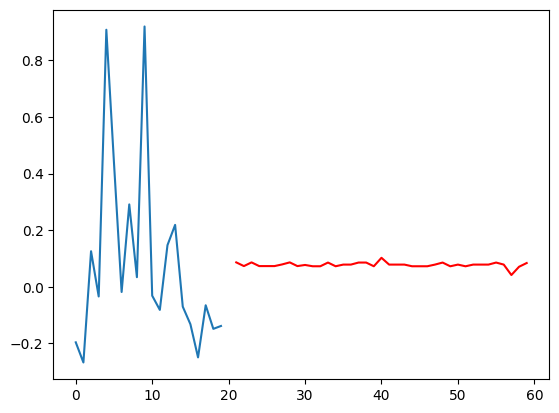

In [12]:
#plt.hist(y_train, bins=40);
plt.plot(range(0,20), y_train[len(y_train)-20:]);
plt.plot(range(21,60),y_pred, color = 'r');

### Model with N-Fold&GridSerch

In [ ]:
## 
# param_grid = {
#     'n_estimators': [500],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [6],
#     'min_split_gain': [1e-6],
#     'num_leaves': [32]
# }

# Data loading
# start_dt = 1698 - 200
# end_dt = 1698

# X_train = (pl.scan_parquet(os.path.join(path, "train.parquet"))
#            .filter(pl.col("date_id").is_between(start_dt, end_dt))
#            .drop(responders)
#            .drop('partition_id', 'weight')
#            .collect()
#            .to_numpy()
#            .astype(np.float32))

# y_train = (pl.scan_parquet(os.path.join(path, "train.parquet"))
#            .filter(pl.col("date_id").is_between(start_dt, end_dt))
#            .select(target)
#            .collect()
#            .to_numpy()
#            .flatten())

# weights = (pl.scan_parquet(os.path.join(path, "train.parquet"))
#            .filter(pl.col("date_id").is_between(start_dt, end_dt))
#            .select('weight')
#            .collect()
#            .to_numpy()
#            .flatten())

# X_val = (pl.scan_parquet(os.path.join(path, "test.parquet"))
#          .drop('row_id', 'is_scored', 'weight')
#          .collect()
#          .to_numpy()
#          .astype(np.float32))

# GridSearchCV setup


# model = lgb.LGBMRegressor(objective="regression", random_state=42)
#tscv = TimeSeriesSplit(n_splits=3)

# grid_search = GridSearchCV(
#     model,
#     param_grid,
#     cv=tscv,  # Use 3-fold cross-validation, data is not shuffled
#     scoring='neg_mean_squared_error',
#     verbose=1
# )

# Fit GridSearchCV
# grid_search.fit(X_train, y_train, sample_weight=weights)

# Best parameters and model
# print("Best parameters found:", grid_search.best_params_)
# best_model = grid_search.best_estimator_


# # Fit the best model on the full training set
# model.fit(X_train, y_train, sample_weight=weights)


In [5]:
# # Разбиение по времени

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 6, 9],
#     'num_leaves': [16, 32, 64],
# }

# for i in range(4;8):
#     start_dt =  i * 212 #31698 - 250
#     end_dt = start_dt + 212  #1698

#     # loading train 
#     X_train = (pl.scan_parquet(os.path.join(path, "train.parquet"))
#         .filter(pl.col("date_id").is_between(start_dt, end_dt))
#         .drop(target)
#         .collect()
#         .to_numpy()
#        .astype(np.float32))

#     y_train = (pl.scan_parquet(os.path.join(path, "train.parquet"))
#         .filter(pl.col("date_id").is_between(start_dt, end_dt))
#         .select(target)
#         .collect()
#         .flatten())

#     weights = (pl.scan_parquet(os.path.join(path, "train.parquet"))
#         .filter(pl.col("date_id").is_between(start_dt, end_dt))
#         .select('weight')
#         .collect()
#         .to_numpy()
#        .astype(np.float32))


#     #X_train_fold = X_train.to_numpy().astype(np.float32)
#     #y_train_fold = y_train.to_numpy().flatten()
#     #weights = weights.to_numpy().flatten() #.astype(np.float32)


#     # Dividing into train, validation
#     split_index = int(0.8 * len(X_train))  
#     X_train, X_val = X_train[:split_index], X_train[split_index:]
#     y_train, y_val = y_train[:split_index], y_train[split_index:]
#     weights_val = weights[split_index:]
#     print('Данные загружены')

#     # Use GridSearchCV to find the best parameters
#     model = lgb.LGBMRegressor(objective="regression", random_state=42)

#     grid_search = GridSearchCV(
#         model,
#         param_grid,
#         cv=3,  # 3-fold cross-validation on the training set
#         scoring='neg_mean_squared_error',
#         verbose=1
#     )

#     grid_search.fit(X_train_fold, y_train_fold, sample_weight=weights_train)

#     print("Best parameters found:", grid_search.best_params_)

#     # Train the model with the best parameters
#     best_model = grid_search.best_estimator_
#     best_model.fit(X_train_fold, y_train_fold, sample_weight=weights_train)

#     print('Model trained on fold:', i + 1)

#     # Free up memory
#     del X_train, y_train, weights, X_train_fold, y_train_fold
#     gc.collect()

#     # Make predictions
#     y_pred = best_model.predict(X_val)
#     fold_r2 = weighted_r2(y_val, y_pred, weights_val)
#     fold_errors.append(fold_r2)

#     print(f"Fold {i+1} Weighted R2: {fold_r2}")

# # Calculate mean R2 score across all folds
# mean_r2 = np.mean(fold_errors)
# print(f"Mean Weighted R2 across all folds: {mean_r2}")

In [ ]:
#model.save("/kaggle/working/model")

In [ ]:
# X_test = (pl.scan_parquet(os.path.join(path, "test.parquet"))
#   #  .filter(pl.col("date_id").is_between(start_dt, end_dt))
#     .drop('row_id', 'is_scored')
#     .collect())
    
# y_pred_submission = model.predict(X_test)

## Draft

In [ ]:
# X_full_train = (pl.scan_parquet(os.path.join(path, "train.parquet"))
#     .drop(target, 'weight')
#     .collect()
#     .to_numpy()
#     .astype(np.float32))

# y_full_train = (pl.scan_parquet(os.path.join(path, "train.parquet"))
#     .select(target)
#     .collect()
#     .to_numpy()
#     .flatten())

# weights_full = (pl.scan_parquet(os.path.join(path, "train.parquet"))
#     .select('weight')
#     .collect()
#     .to_numpy()
#     .flatten())

# final_model = lgb.LGBMRegressor(
#     objective="regression",
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=6,
#     random_state=42,
#     num_leaves=64,
#     min_split_gain=0.0
# )
# final_model.fit(X_full_train, y_full_train, sample_weight=weights_full)

In [ ]:
#tab.info()
#train.describe()
#plt.plot(X_train['date_id'], X_train['feature_45']);
#print('Unique financial instuments: ', X_train['symbol_id'].nunique())

Уменьшение использование памяти за счет типа данных

In [ ]:
# def reduce_memory_usage(df, use_float32=True):


#     for col in df.columns:
#         col_type = df[col].dtype

#         # Process numeric columns only
#         if pd.api.types.is_numeric_dtype(col_type):
#             col_min = df[col].min()
#             col_max = df[col].max()

#             # Downcast integer columns
#             if pd.api.types.is_integer_dtype(col_type):
#                 if col_min >= np.iinfo(np.int8).min and col_max <= np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif col_min >= np.iinfo(np.int16).min and col_max <= np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif col_min >= np.iinfo(np.int32).min and col_max <= np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 else:
#                     df[col] = df[col].astype(np.int64)

#             # Downcast floating-point columns
#             elif pd.api.types.is_float_dtype(col_type):
#                 if use_float32:
#                     if col_min >= np.finfo(np.float32).min and col_max <= np.finfo(np.float32).max:
#                         df[col] = df[col].astype(np.float32)
#                 else:
#                     if col_min >= np.finfo(np.float16).min and col_max <= np.finfo(np.float16).max:
#                         df[col] = df[col].astype(np.float16)


#     return df

Загрузка паркетов

In [ ]:
# !pip install fastparquet -q
# import fastparquet
# i = 9
# tab  = pd.read_parquet(f'/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id={i}/part-0.parquet'
#                 , engine = 'fastparquet')
# tab.tail(2)

In [ ]:
#кол-во дат
1698/8